# Single Step Prediction

Training on market prices $x_1,...,x_n$:

- Input: prices $x_1,...,x_s$, where $s = 7\cdot 24$ (1 week)
- Output: prediction for next price $x_{s+1}$

In [29]:
import os
import torch
from torch import nn, Tensor, optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('../../data/time.csv')
raw_data = np.array(df['GRID (OMIE) Price (€/MWh)'].values)
scaler = MinMaxScaler()
data = scaler.fit_transform(raw_data.reshape(-1, 1)).reshape(-1)

In [ ]:
class TimeSeriesDataset(Dataset):
  def __init__(self, data: np.ndarray, seq_len: int):
    self.data = data
    self.seq_len = seq_len

  def __len__(self):
    return len(self.data) - self.seq_len

  def __getitem__(self, idx: int):
    end = idx+self.seq_len
    x = self.data[idx:end] # input: data[idx], data[idx+1], ..., data[end-1]
    y = self.data[end] # output: data[end]
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
  
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

SEQ_LEN = 7*24 # input sequence length (1 week)
train_ds = TimeSeriesDataset(train_data, SEQ_LEN)
test_ds = TimeSeriesDataset(test_data, SEQ_LEN)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False)

In [33]:
class LSTMModel(nn.Module):
  def __init__(self, hidden_size = 50, num_layers = 2):
    super(LSTMModel, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x: Tensor):
    """
    - `x`: shape (batch, seq_len)
    - output: shape (batch,)
    """
    out, _ = self.lstm(x[..., None].float())
    pred = out[:, -1] # last time step only
    return self.fc(pred)[:, 0]
  
def train_step(
    model, x: Tensor, y: Tensor,
    *, opt: optim.Optimizer, criterion
  ) -> float:
    """
    - `x`: shape (batch, seq_len)
    - `y`: shape (batch,)
    """
    if not model.training:
      model.train()
    opt.zero_grad()
    z = model(x)
    loss: Tensor = criterion(z, y)
    loss.backward()
    opt.step()
    return loss.item()
  
def eval_step(
  model, x: Tensor, y: Tensor,
  *, criterion
) -> float:
  """
  - `x`: shape (batch, seq_len)
  - `y`: shape (batch,)
  """
  if model.training:
    model.eval()
  with torch.no_grad():
    z = model(x)
    loss: Tensor = criterion(z, y)
    return loss.item()
  
model = LSTMModel()
criterion = nn.MSELoss()
opt = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
RUN_NAME = 'weekly'
os.makedirs(f'checkpoints/{RUN_NAME}', exist_ok=True)

for epoch in range(50):
  n = len(train_loader)
  model.train()
  losses = []
  for i, (x, y) in enumerate(train_loader):
    print(f'\rEpoch {epoch+1} [{i+1}/{n} ({(i+1)/n:.2%})]...', end='', flush=True)
    loss = train_step(model, x, y, opt=opt, criterion=criterion)
    losses.append(loss)

  train_loss = torch.tensor(losses).mean().item()

  losses = []
  n = len(test_loader)
  for i, (x, y) in enumerate(test_loader):
    print(f'\rEpoch {epoch+1}, train_loss={train_loss:.6f}. Evaluating... [{i+1}/{n} ({(i+1)/n:.2%})]', end='', flush=True)
    loss = eval_step(model, x, y, criterion=criterion)
    losses.append(loss)

  test_loss = torch.tensor(losses).mean().item()
  print(f'\rEpoch {epoch+1}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}' + ' '*80)
  torch.save(model.state_dict(), f'checkpoints/{RUN_NAME}/{epoch+1}.pth')

Epoch 1, train_loss=0.029752, test_loss=0.012230                                                                                
Epoch 2, train_loss=0.008912, test_loss=0.011122                                                                                
Epoch 3, train_loss=0.007475, test_loss=0.007953                                                                                
Epoch 4, train_loss=0.008796, test_loss=0.007393                                                                                
Epoch 5, train_loss=0.006198, test_loss=0.004913                                                                                
Epoch 6, train_loss=0.005182, test_loss=0.004196                                                                                
Epoch 7, train_loss=0.004954, test_loss=0.003694                                                                                
Epoch 8, train_loss=0.004824, test_loss=0.003535                                                 

In [35]:
def generate(model: LSTMModel, input: Tensor, steps: int):
  """Generate `steps` predictions by feeding the model outputs as inputs in the next step.
  - `input`: initial sequence of prices, shape (seq_len,)
  - Returns: predicted prices, shape (steps,)
  """
  model.eval()
  input_seq = input.clone()
  preds = []

  for _ in range(steps):
    with torch.no_grad():
      output: Tensor = model(input_seq[None, ...])
      preds.append(output.item())
      input_seq = torch.cat((input_seq[1:], output), 0)

  return torch.tensor(preds)


print(f'Loading {RUN_NAME}')
model.load_state_dict(torch.load(f'checkpoints/{RUN_NAME}/47.pth', weights_only=True))
model.eval()

Loading 7day


LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

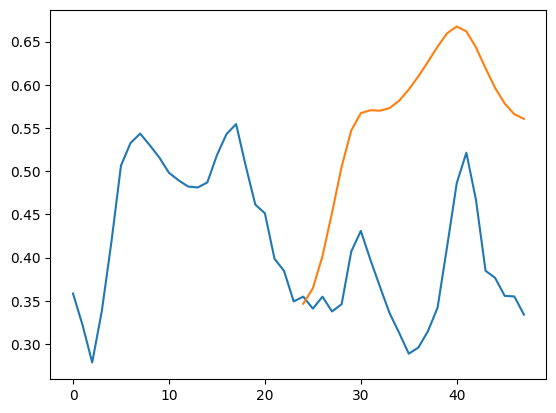

In [ ]:
pred_steps = 24
inp = torch.tensor(test_data[:SEQ_LEN], dtype=torch.float32)
preds = generate(model, inp, pred_steps)

plt.plot(test_data[:SEQ_LEN+pred_steps], label='true')
plt.plot(np.arange(SEQ_LEN, SEQ_LEN+pred_steps), preds, label='predicted')